# PONTIFÍCIA UNIVERSIDADE CATÓLICA DE MINAS GERAIS

## Previsão de rotatividade (Turnover) de funcionários em empresas.

### Aluno: Sebastião Enivanete Rodrigues


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             roc_auc_score,
                             roc_curve,
                             confusion_matrix)
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     learning_curve,
                                     validation_curve,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from warnings import filterwarnings
import matplotlib as matplot
%matplotlib inline
sns.set_context("notebook")
plt.style.use("fivethirtyeight")
filterwarnings("ignore")

import scipy.stats as stats
import seaborn as sns
import urllib.request, json 

### Nesta sessão carregaremos os dados utilizados para este tabalho

In [13]:
turnover = pd.read_csv("D:/PUC MINAS/Disciplinas/13 - TCC - Ciência de Dados de Big Data (2020)/datasets/turnoverBrasil.csv")


Importação dos dados do IBGE

In [14]:
with urllib.request.urlopen("https://servicodados.ibge.gov.br/api/v3/agregados/6442/periodos/-61/variaveis/8677?classificacao=11046[33534]&localidades=N1") as url:
    df_serv = json.loads(url.read().decode())
#df_serv

In [15]:
with urllib.request.urlopen("https://servicodados.ibge.gov.br/api/v3/agregados/3653/periodos/-61/variaveis/4139?classificacao=544[129314]&localidades=N1") as url:
    df_ind = json.loads(url.read().decode())
#df_ind

In [16]:
with urllib.request.urlopen("https://servicodados.ibge.gov.br/api/v3/agregados/3416/periodos/-61/variaveis/564?classificacao=11046[33534]&localidades=N1") as url:
    df_com = json.loads(url.read().decode())
#df_com

#### Busca somente as séries de 2017 para as bases obtidas do IBGE

In [17]:
# busca apenas os dados de 2017, percorrendo o atributo serie
def retorna_2017(df_serv):
    elements = {}
    for i in df_serv:
        for j in i["resultados"]:
            for k in j["series"]:
                for i in k["serie"]:
                    if i[0:4] == "2017":
                        elements[i] = k["serie"][i]
    return elements


print(retorna_2017(df_serv))
df_serv = retorna_2017(df_serv)


{'201701': '1.4', '201702': '1.0', '201703': '-2.8', '201704': '0.9', '201705': '-0.2', '201706': '0.7', '201707': '0.0', '201708': '-0.9', '201709': '-0.3', '201710': '-0.1', '201711': '0.5', '201712': '0.8'}


In [18]:
# busca apenas os dados de 2017, percorrendo o atributo serie
def retorna_2017(df_ind):
    elements = {}
    for i in df_ind:
        for j in i["resultados"]:
            for k in j["series"]:
                for i in k["serie"]:
                    if i[0:4] == "2017":
                        elements[i] = k["serie"][i]
    return elements


print(retorna_2017(df_ind))
df_ind = retorna_2017(df_ind)

{'201701': '1.1', '201702': '1.2', '201703': '-2.1', '201704': '0.4', '201705': '0.3', '201706': '0.9', '201707': '0.3', '201708': '-0.3', '201709': '0.5', '201710': '0.7', '201711': '0.5', '201712': '3.3'}


In [19]:
def retorna_2017(df_com):
    elements = {}
    for i in df_com:
        for j in i["resultados"]:
            for k in j["series"]:
                for i in k["serie"]:
                    if i[0:4] == "2017":
                        elements[i] = k["serie"][i]
    return elements


print(retorna_2017(df_com))
df_com = retorna_2017(df_com)

{'201701': '4.1', '201702': '0.4', '201703': '-0.9', '201704': '1.0', '201705': '0.1', '201706': '1.0', '201707': '-0.4', '201708': '-0.5', '201709': '0.7', '201710': '-0.2', '201711': '0.0', '201712': '0.3'}


#### Calcula as taxas para os setores distintos

In [20]:
# Calcula a taxa de creciemnto para os setor de serviços, somando todas as taxas e dividindo por 12(meses)
i = 0
j = 0
for key, val in df_serv.items():
    i = float(val)
    j = j + i
    taxa_ser = j /12
print(taxa_ser)


0.08333333333333333


In [21]:
# Calcula a taxa de creciemnto para os setor de indústria, somando todas as taxas e dividindo por 12(meses)
i = 0
j = 0
for key, val in df_ind.items():
    i = float(val)
    j = j + i
    taxa_ind = j /12
print(taxa_ind)

0.5666666666666667


In [22]:
# Calcula a taxa de creciemnto para os setor de comércio, somando todas as taxas e dividindo por 12(meses)
i = 0
j = 0
for key, val in df_com.items():
    i = float(val)
    j = j + i
    taxa_com = j /12
print(taxa_com)

0.46666666666666656


### Verifica se existem dados nulos no dataset.

In [23]:
turnover.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
sales                    False
salary                   False
dtype: bool

#### Vamos verificar os setores distintos existentes no dataset.

In [24]:
#conta o numeros de setores distintos no dataset
setor = []
for i in range(0, len(turnover['sales'])):
    
    if turnover['sales'][i] not in setor: 
        
        setor.append(turnover['sales'][i])
  
print("Valores Unicos :",
      setor)

Valores Unicos : ['sales', 'accounting', 'hr', 'technical', 'support', 'management', 'IT', 'product_mng', 'marketing', 'RandD']


#### Agora que já sabemos quais são nossos setores, vamos concatenar as taxas de crescimento obtidas no dataset anterior aos setores do dataset turnover.

In [25]:
#atribui a as taxas de crescimento de acordo o setor
turnover.loc[turnover['sales']=='sales','crescimento_anual_setor']= float(round(taxa_com, 2))
turnover.loc[turnover['sales']=='accounting','crescimento_anual_setor']= float(round(float(round(taxa_ser, 2)), 2))
turnover.loc[turnover['sales']=='hr','crescimento_anual_setor']= float(round(taxa_ser, 2))
turnover.loc[turnover['sales']=='technical','crescimento_anual_setor']= float(round(taxa_ind, 2))
turnover.loc[turnover['sales']=='support','crescimento_anual_setor']= float(round(taxa_ser, 2))
turnover.loc[turnover['sales']=='management','crescimento_anual_setor']= float(round(taxa_ser, 2))
turnover.loc[turnover['sales']=='product_mng','crescimento_anual_setor']= float(round(taxa_com, 2))
turnover.loc[turnover['sales']=='IT','crescimento_anual_setor']= float(round(taxa_ser, 2))
turnover.loc[turnover['sales']=='marketing','crescimento_anual_setor']= float(round(taxa_ser, 2))
turnover.loc[turnover['sales']=='RandD','crescimento_anual_setor']= float(round(taxa_ind, 2))

#### Vamos renomear as colunas do dataset para facilitar as próximas análises

In [26]:
df = turnover 
df = df.rename(columns={'satisfaction_level': 'satisfacao', 
                        'last_evaluation': 'ultima_avaliacao_desempenho',
                        'number_project': 'numero_projetos',
                        'average_montly_hours': 'media_horas_mensais',
                        'time_spend_company': 'tempo_na_empresa',
                        'Work_accident': 'acidentes_de_trabalho',
                        'promotion_last_5years': 'promocao',
                        'sales' : 'departamento',
                        'salary' : 'salario',
                        'left' : 'turnover'
                        })

### Nesta sessão iremos fazer a análise exploratória.

In [27]:
#vamos trocar a posição da variavel turnover
posicao = df['turnover']
df.drop(labels=['turnover'], axis=1,inplace = True)
df.insert(0, 'turnover', posicao)
df.head()

,turnover,satisfacao,ultima_avaliacao_desempenho,numero_projetos,media_horas_mensais,tempo_na_empresa,acidentes_de_trabalho,promocao,departamento,salario,crescimento_anual_setor
0,1,0.38,0.53,2,157,3,0,0,sales,low,0.47
1,1,0.80,0.86,5,262,6,0,0,sales,medium,0.47
2,1,0.11,0.88,7,272,4,0,0,sales,medium,0.47
3,1,0.72,0.87,5,223,5,0,0,sales,low,0.47
4,1,0.37,0.52,2,159,3,0,0,sales,low,0.47


####  vamos verificar a distribuição da nossa variável alvo e também fazer uma estatística descritiva. Verificaremos também a média destas variáveis.

In [255]:
#vamos dar uma olhada na nossa taxa de turnover
taxa_turnover = df.turnover.value_counts() / len(df)
taxa_turnover

0    0.761917
1    0.238083
Name: turnover, dtype: float64

In [256]:
df.describe()

,turnover,satisfacao,ultima_avaliacao_desempenho,numero_projetos,media_horas_mensais,tempo_na_empresa,acidentes_de_trabalho,promocao,crescimento_anual_setor
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.238083,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268,0.325670
std,0.425924,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281,0.216605
min,0.000000,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.080000
25%,0.000000,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.080000
50%,0.000000,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.470000
75%,0.000000,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.470000
max,1.000000,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,0.570000


In [257]:
#Vamos comparar nossas medias entre quem saiu e quem ficou
turnover_Summary = df.groupby('turnover')
turnover_Summary.mean()

,satisfacao,ultima_avaliacao_desempenho,numero_projetos,media_horas_mensais,tempo_na_empresa,acidentes_de_trabalho,promocao,crescimento_anual_setor
turnover,,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251,0.326002
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321,0.324609


### Correlação das variáveis.

,turnover,satisfacao,ultima_avaliacao_desempenho,numero_projetos,media_horas_mensais,tempo_na_empresa,acidentes_de_trabalho,promocao,crescimento_anual_setor
turnover,1.000000,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,-0.061788,-0.002738
satisfacao,-0.388375,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,0.025605,0.001378
ultima_avaliacao_desempenho,0.006567,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,-0.008684,-0.010171
numero_projetos,0.023787,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,-0.006064,0.019399
media_horas_mensais,0.071287,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,-0.003544,0.007559
tempo_na_empresa,0.144822,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.067433,-0.024534
acidentes_de_trabalho,-0.154622,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,0.039245,-0.000087
promocao,-0.061788,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,1.000000,-0.026495
crescimento_anual_setor,-0.002738,0.001378,-0.010171,0.019399,0.007559,-0.024534,-0.000087,-0.026495,1.000000


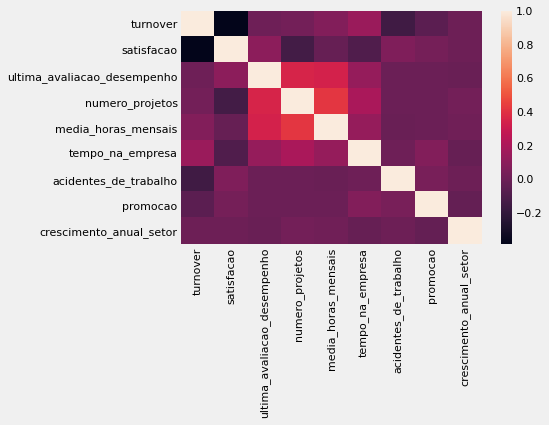

In [258]:
corr = df.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

corr

#### Vimos através a matriz acima que a satisfação tem a maior correlação  com a variável turnover. 

In [198]:
#Medias de satisfação 
emp_populacao = df['satisfacao'][df['turnover'] == 0].mean()
emp_turnover_satisfacao = df[df['turnover']==1]['satisfacao'].mean()

print( 'Satisfação média de funcionarios que ficou na empresa é: ' + str(emp_populacao))
print( 'Satisfação média de funcionarios que sairam da empresa é: ' + str(emp_turnover_satisfacao) )

Satisfação média de funcionarios que ficou na empresa é: 0.666809590479516
Satisfação média de funcionarios que sairam da empresa é: 0.44009801176140917


#### Vamos realizar um teste t com nível de confiança de 95% e ver se ele rejeita corretamente a hipótese nula de que a amostra vem da mesma distribuição que a população de funcionários. Para realizar um teste t de uma amostra, podemos usar a função stats.ttest_1samp():


In [199]:
stats.ttest_1samp(a=  df[df['turnover']==1]['satisfacao'],# amostra da população que saiu(turnover = 1)
                  popmean = emp_populacao) 

Ttest_1sampResult(statistic=-51.3303486754725, pvalue=0.0)

In [200]:
degree_freedom = len(df[df['turnover']==1])

LQ = stats.t.ppf(0.025,degree_freedom)  # primeiro quartil

RQ = stats.t.ppf(0.975,degree_freedom)  # quarto quartil

print ('Intervalo do quartil esquerdo da distribuição é: ' + str(LQ))
print ('TIntervalo do quartil direito da distribuição é ' + str(RQ))

Intervalo do quartil esquerdo da distribuição é: -1.9606285215955626
TIntervalo do quartil direito da distribuição é 1.9606285215955621


#### Distribuição das variáveis  satisfação, avaliação de desempenho e média de horas mensais.

Text(0, 0.5, 'Numero de funcioanarios')

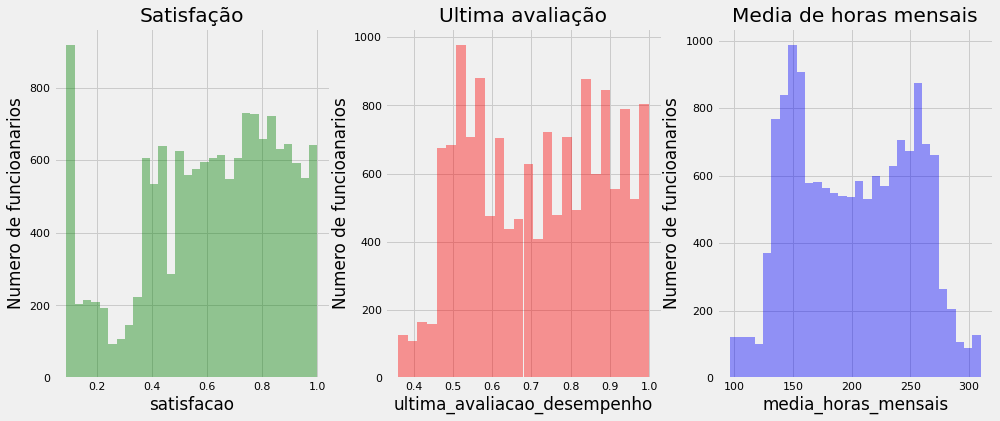

In [201]:
# gráficos de distribuição entre satisfação, avaliação de desempenho e média de horas mensais
f, axes = plt.subplots(ncols=3, figsize=(15, 6))

sns.distplot(df.satisfacao, kde=False, color="g", ax=axes[0]).set_title('Satisfação')
axes[0].set_ylabel('Numero de funcioanarios')

sns.distplot(df.ultima_avaliacao_desempenho, kde=False, color="r", ax=axes[1]).set_title('Ultima avaliação')
axes[1].set_ylabel('Numero de funcioanarios')

sns.distplot(df.media_horas_mensais, kde=False, color="b", ax=axes[2]).set_title('Media de horas mensais')
axes[2].set_ylabel('Numero de funcioanarios')

### Análise de turnover e salário

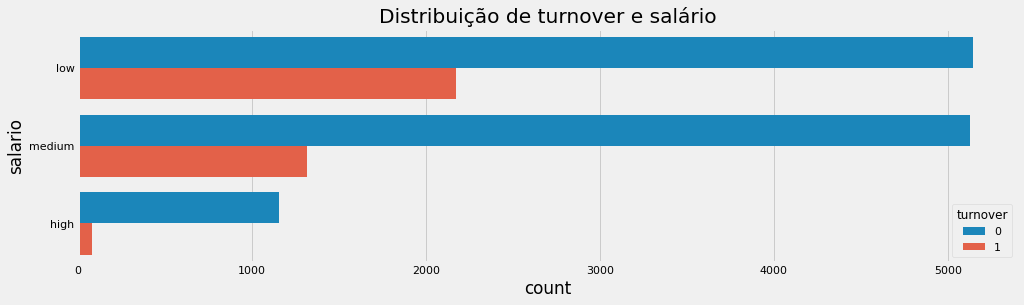

In [202]:
#vamos avaliar a relação entre salarios e turnover
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="salario", hue='turnover', data=df).set_title('Distribuição de turnover e salário');

### Análise de turnover x departamentos

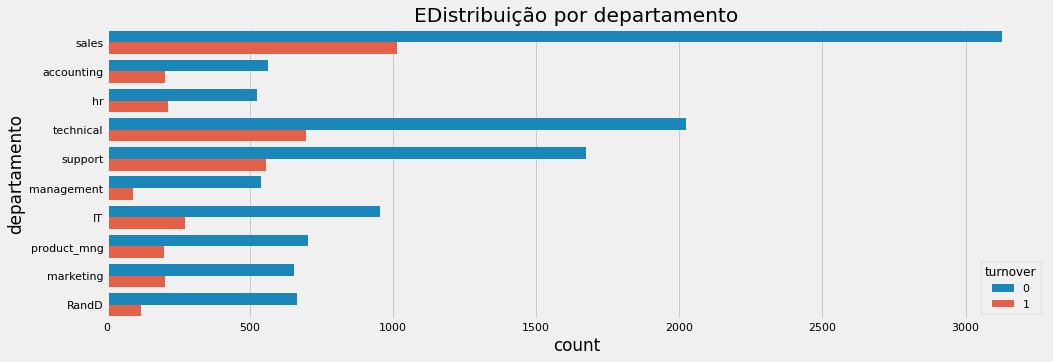

In [203]:
#Turnover x departamentos
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(y="departamento", hue='turnover', data=df).set_title('Distribuição por departamento');

### Análise de turnover x número de projetos

[Text(0, 0.5, 'Percent')]

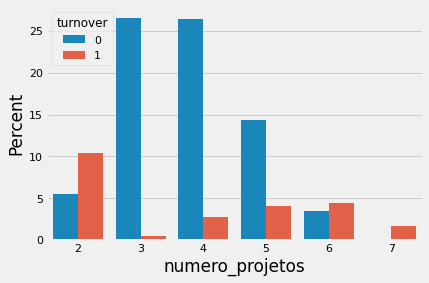

In [204]:
# Análise turnover x número de projetos
ax = sns.barplot(x="numero_projetos", y="numero_projetos", hue="turnover", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")

### Análise de turnover x não turnover e avaliação de desempenho.

Text(0.5, 1.0, 'Distribuição do desempenho dos Funcioanrios - Turnover V.S. Não Turnover')

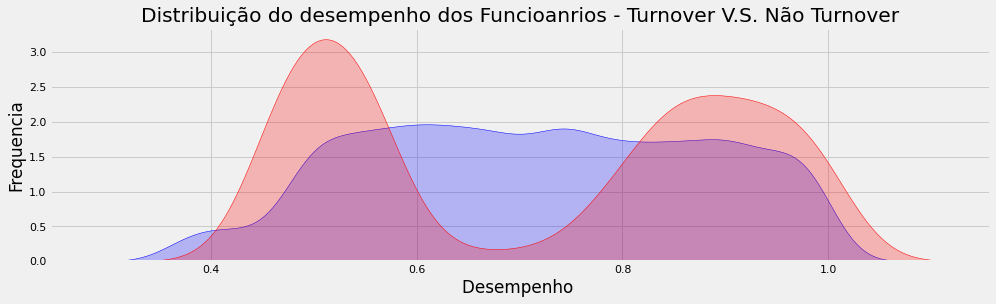

In [205]:
# Avaliação de desempenho x turnover
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'ultima_avaliacao_desempenho'] , color='b',shade=True,label='no turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'ultima_avaliacao_desempenho'] , color='r',shade=True, label='turnover')
ax.set(xlabel='Desempenho ', ylabel='Frequencia')
plt.title('Distribuição do desempenho dos Funcioanrios - Turnover V.S. Não Turnover')


### Análise de turnover x crescimento setorial

Text(0.5, 1.0, 'Distribuição crescimento setor dos Funcioanrios - Turnover V.S. Não Turnover')

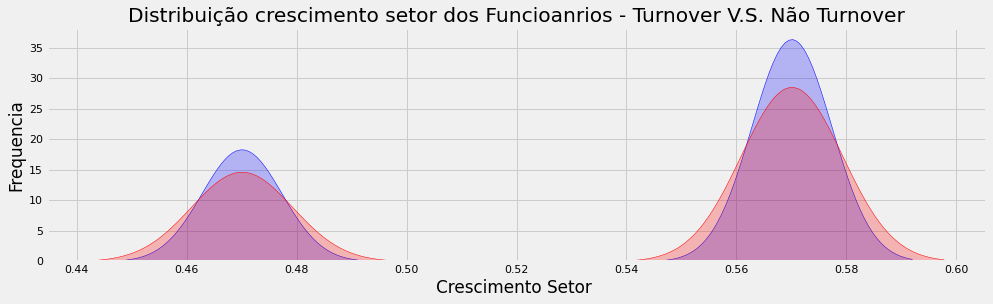

In [213]:
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'crescimento_anual_setor'] , color='b',shade=True,label='no turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'crescimento_anual_setor'] , color='r',shade=True, label='turnover')
ax.set(xlabel='Crescimento Setor ', ylabel='Frequência')
plt.title('Distribuição crescimento setor dos Funcioanrios - Turnover V.S. Não Turnover')

### Análise de turnover x não turnover e horas mensais de trabalho

Text(0.5, 1.0, 'Distribuição da media de horas mensais de trabalho dos Funcioanrios - Turnover V.S. No Turnover')

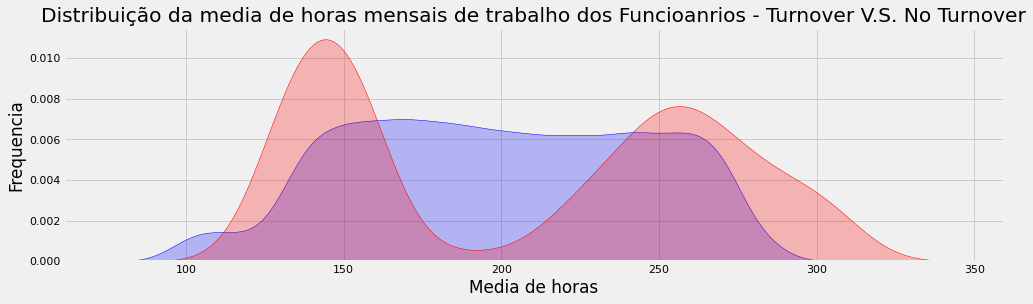

In [206]:
# Turnover x horas mensais trabalhadas
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'media_horas_mensais'] , color='b',shade=True, label='não turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'media_horas_mensais'] , color='r',shade=True, label='turnover')
ax.set(xlabel='Media de horas', ylabel='Frequencia')
plt.title('Distribuição da media de horas mensais de trabalho dos Funcioánrios - Turnover V.S. No Turnover')

### Análise de turnover x não turnover e satisfação 

Text(0.5, 1.0, 'Distribuicao de satisfacao - Turnover V.S. Não Turnover')

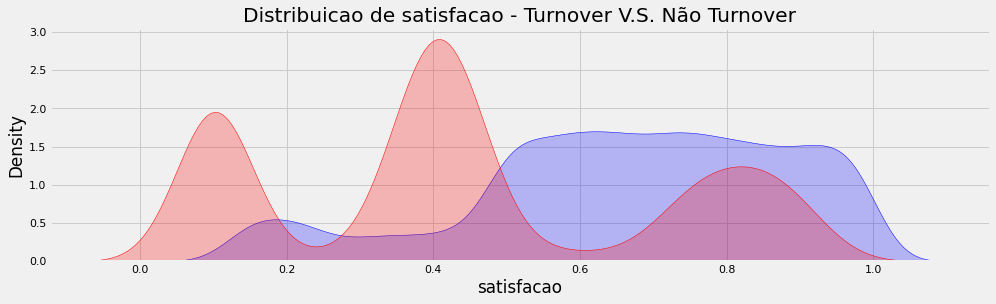

In [207]:
#Satisfação x turnover
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'satisfacao'] , color='b',shade=True, label='não turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'satisfacao'] , color='r',shade=True, label='turnover')
plt.title('Distribuicao de satisfacao - Turnover V.S. Não Turnover')

### Análise de turnover x número de projetos x medias de horas mensais trabalhadas

<AxesSubplot:xlabel='numero_projetos', ylabel='media_horas_mensais'>

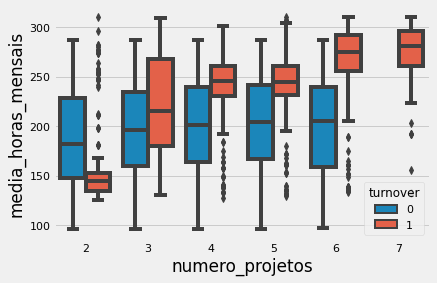

In [208]:
# Turnover x numero de projetos x medias de horas trablhadas
sns.boxplot(x="numero_projetos", y="media_horas_mensais", hue="turnover", data=df)

### Análise de turnover x numero de projetos x avaliação de desempenho
sns.boxplot(x="numero_projetos", y="media_horas_mensais", hue="turnover", data=df)

<AxesSubplot:xlabel='numero_projetos', ylabel='ultima_avaliacao_desempenho'>

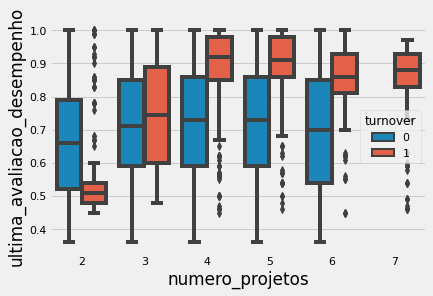

In [158]:
#Turnover x desempenho x Números de projetos
sns.boxplot(x="numero_projetos", y="ultima_avaliacao_desempenho", hue="turnover", data=df)

### Análise e agrupamento de turnover x satisfação x avaliação de desempenho

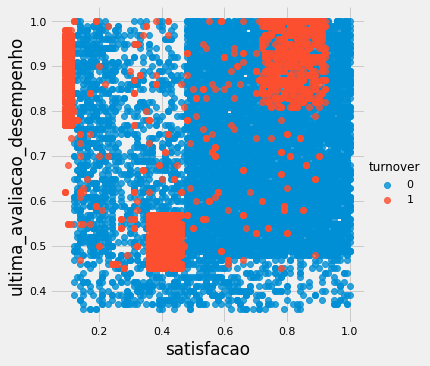

In [159]:
# desempenho x numero de projetos
sns.lmplot(x='satisfacao', y='ultima_avaliacao_desempenho', data=df,
           fit_reg=False, 
           hue='turnover')   

### Análise de turnover x tempo de trabalho na empresa em anos

[Text(0, 0.5, 'Percentual')]

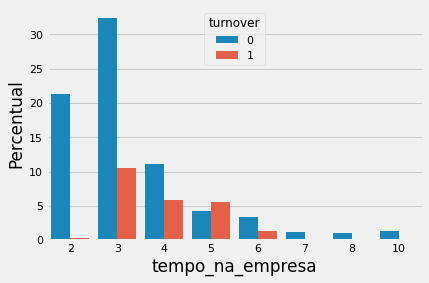

In [160]:
ax = sns.barplot(x="tempo_na_empresa", y="tempo_na_empresa", hue="turnover", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percentual")

### Processos preliminares antes de aplicar os modelos

#### Antes de testarmos os modelos, vamos fazer mais alguns tratamentos de dados. Temos a variável salário como tipo categórica, devemos a converter para nominal pra melhorar o desempenho dos algoritmos. Vamos também criar uma coluna para cada departamento e vamos atribuir a elas valores ordinais (0 e 1) para cada na coluna criada.

In [161]:
#transforma salario de categórico para ordinal
salario_ord = {"low": 0, "medium": 1, "high": 2}
df["salario"] = df["salario"].map(salario_ord)

#Vamos criar novas colunas para os departamentos, onde cada departamento terá sua própria coluna.
df = pd.get_dummies(df, columns=["departamento"], drop_first=True)
df.head()

,turnover,satisfacao,ultima_avaliacao_desempenho,numero_projetos,media_horas_mensais,tempo_na_empresa,acidentes_de_trabalho,promocao,salario,crescimento_anual_setor,departamento_RandD,departamento_accounting,departamento_hr,departamento_management,departamento_marketing,departamento_product_mng,departamento_sales,departamento_support,departamento_technical
0,1,0.38,0.53,2,157,3,0,0,0,0.47,0,0,0,0,0,0,1,0,0
1,1,0.80,0.86,5,262,6,0,0,1,0.47,0,0,0,0,0,0,1,0,0
2,1,0.11,0.88,7,272,4,0,0,1,0.47,0,0,0,0,0,0,1,0,0
3,1,0.72,0.87,5,223,5,0,0,0,0.47,0,0,0,0,0,0,1,0,0
4,1,0.37,0.52,2,159,3,0,0,0,0.47,0,0,0,0,0,0,1,0,0


#### Como se trata de uma base desequilibrada, vamos fazer alguns ajustes. Testaremos alguns recursos de upsampled e downsampled para vermos qual dará um resultado mais confiável.

In [162]:
#divisão da base em 80/20 
X = df.loc[:, df.columns != "turnover"].values
y = df.loc[:, df.columns == "turnover"].values.flatten()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

# Upsampled da clssse minoritaria
X_train_up, y_train_up = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)
X_train_up = np.concatenate((X_train[y_train == 0], X_train_up))
y_train_up = np.concatenate((y_train[y_train == 0], y_train_up))

# Downsampled classe majoritaria
X_train_down, y_train_down = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_down = np.concatenate((X_train[y_train == 1], X_train_down))
y_train_down = np.concatenate((y_train[y_train == 1], y_train_down))

print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_up.shape, y_train_up.shape)
print("Downsampled shape:", X_train_down.shape, y_train_down.shape)

Original shape: (11999, 18) (11999,)
Upsampled shape: (18284, 18) (18284,)
Downsampled shape: (5714, 18) (5714,)


#### Vamos então rodar um modelo de Randon Forest para verificar quais são os mehores parametros obtidos.

In [163]:
#Randon forest-- usado validação cruzada de 10 vezes
df_trabalhado = {"Original": (X_train, y_train),
                "Upsampled": (X_train_up, y_train_up),
                "Downsampled": (X_train_down, y_train_down)}

for method in df_trabalhado.keys():
    pipeline = make_pipeline(StandardScaler(),
                           RandomForestClassifier(n_estimators=500,
                                                  class_weight="balanced",
                                                  random_state=123))
    
    hyperparam_grid = {
        "randomforestclassifier__n_estimators": [10, 50, 100, 500],
        "randomforestclassifier__max_features": ["sqrt", "log2", 0.4, 0.5],
        "randomforestclassifier__min_samples_leaf": [1, 3, 5],
        "randomforestclassifier__criterion": ["gini", "entropy"]}
    
    grid = GridSearchCV(pipeline,
                         hyperparam_grid,
                         scoring="f1",
                         cv=10,
                         n_jobs=-1)
    
    grid.fit(df_trabalhado[method][0], df_trabalhado[method][1])
    
    print("\033[1m" + "\033[0m" + "O melhor parametro para dados {} :".format(method))
    for hyperparam in grid.best_params_.keys():
        print(hyperparam[hyperparam.find("__") + 2:], ": ", grid.best_params_[hyperparam])
        
    print("\033[1m" + "\033[94m" + "Melhor 10-folds validação cruzada f1-score: {:.2f}%.".format((grid.best_score_) * 100))

O melhor parametro para dados Original :
criterion :  gini
max_features :  0.5
min_samples_leaf :  1
n_estimators :  500
Melhor 10-folds validação cruzada f1-score: 98.21%.
O melhor parametro para dados Upsampled :
criterion :  gini
max_features :  0.4
min_samples_leaf :  1
n_estimators :  50
Melhor 10-folds validação cruzada f1-score: 99.80%.
O melhor parametro para dados Downsampled :
criterion :  gini
max_features :  0.4
min_samples_leaf :  1
n_estimators :  100
Melhor 10-folds validação cruzada f1-score: 98.40%.


## Aplicando os modelos preditivos

### Vamos reajustar o modeloRandon Forest com os melhores hiperparametros obtidos.

In [164]:
#atribui-se novamente aos resultados de testes atuais os resultados de dados com upsampled
X_train, y_train = np.copy(X_train_up), np.copy(y_train_up)

# Exclui os dados originais e downsampled
del X_train_up, y_train_up, X_train_down, y_train_down

# Refit RF classifier using best params
classificador = make_pipeline(StandardScaler(),
                       RandomForestClassifier(n_estimators=50,
                                              criterion="gini",
                                              max_features=0.4,
                                              min_samples_leaf=1,
                                              class_weight="balanced",
                                              n_jobs=-1,
                                              random_state=123))


classificador.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features=0.4, n_estimators=50,
                                        n_jobs=-1, random_state=123))])

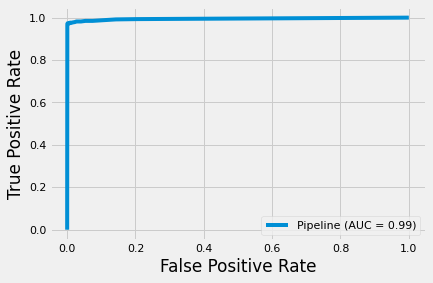

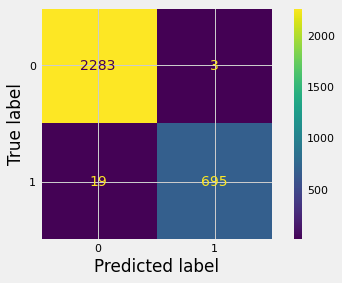

In [165]:
metrics.plot_roc_curve(classificador, X_test, y_test) 
metrics.plot_confusion_matrix(classificador, X_test, y_test)

### Vamos analisar  o gradient bosting

In [166]:
pipeline_gb = make_pipeline(StandardScaler(),
                       GradientBoostingClassifier(loss="deviance",
                                                  random_state=123))

hyperparam_grid = {"gradientboostingclassifier__max_features": ["log2", 0.5],
                   "gradientboostingclassifier__n_estimators": [100, 300, 500],
                   "gradientboostingclassifier__learning_rate": [0.001, 0.01, 0.1],
                   "gradientboostingclassifier__max_depth": [1, 2, 3]}

gridSearch_gb = GridSearchCV(pipeline_gb,
                      param_grid=hyperparam_grid,
                      scoring="f1",
                      cv=10,
                      n_jobs=-1)

gridSearch_gb.fit(X_train, y_train)

print("\033[1m" + "\033[0m" + "Melhores hiperparametros:")
print("-" * 25)
for hyperparam in gridSearch_gb.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", gridSearch_gb.best_params_[hyperparam])

print("\033[1m" + "\033[94m" + "Melhor 10-folds validação cruzada f1-score: {:.2f}%.".format((gridSearch_gb.best_score_) * 100))

Melhores hiperparametros:
-------------------------
learning_rate :  0.1
max_depth :  3
max_features :  0.5
n_estimators :  500
Melhor 10-folds validação cruzada f1-score: 97.96%.


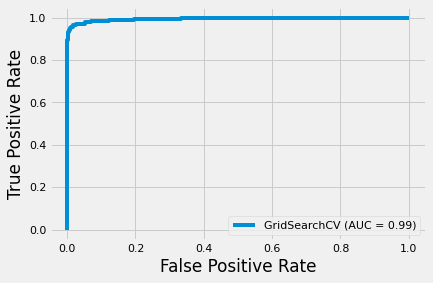

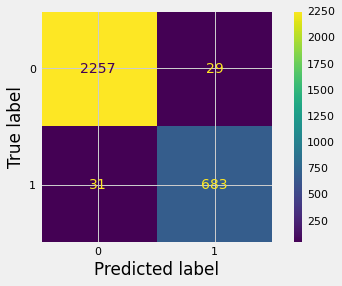

In [167]:
metrics.plot_roc_curve(gridSearch_gb, X_test, y_test) 
metrics.plot_confusion_matrix(gridSearch_gb, X_test, y_test)

### Vamos então aplicar o um classificador KNN

In [169]:
# Knn
pipeline_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
hyperparam_range = range(1, 20)

grid_knn = GridSearchCV(pipeline_knn,
                      param_grid={"kneighborsclassifier__n_neighbors": hyperparam_range,
                                  "kneighborsclassifier__weights": ["uniform", "distance"]},#pesos e distancia
                      scoring="f1",
                      cv=10,
                      n_jobs=-1)

grid_knn.fit(X_train, y_train)


print("\033[1m" + "\033[0m" + "Melhores parâmetros:")
print("-" * 25)
for hyperparam in grid_knn.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", grid_knn.best_params_[hyperparam])

print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((grid_knn.best_score_) * 100))

Melhores parâmetros:
-------------------------
n_neighbors :  1
weights :  uniform
Best 10-folds CV f1-score: 98.24%.


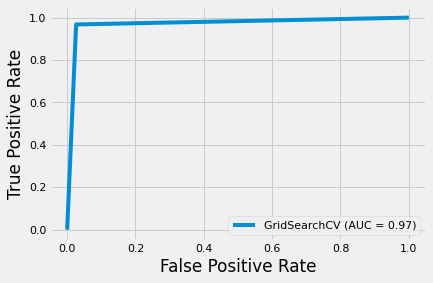

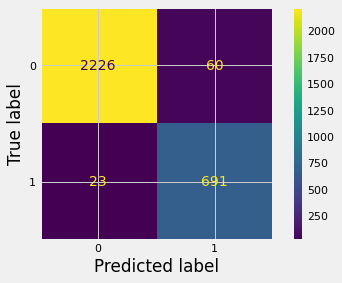

In [170]:
metrics.plot_roc_curve(grid_knn, X_test, y_test) 
metrics.plot_confusion_matrix(grid_knn, X_test, y_test)

### Regressão Logística

In [171]:
# Modelo de Regressão logística
pipeline_lr = make_pipeline(StandardScaler(),
                           LogisticRegression(class_weight="balanced"))

hyper_param_range = np.arange(0.5, 20.1, 0.5)

hyper_param_grid = {"logisticregression__penalty": ["l1", "l2"],
                   "logisticregression__C":  hyper_param_range,
                   "logisticregression__fit_intercept": [True, False]
                  }

logReg = GridSearchCV(pipeline_lr,
                           hyper_param_grid,
                           scoring="accuracy",
                           cv=2,
                           n_jobs=-1)

logReg.fit(X_train, y_train)

print("\033[1m" + "\033[0m" + "E os melhores parametros são:")
print("-" * 25)
for hyperparam in logReg.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", logReg.best_params_[hyperparam])

print("\033[1m" + "\033[94m" + "Melhores 10 - folds e validação cruzada: {:.2f}%.".format((logReg.best_score_) * 100))

E os melhores parametros são:
-------------------------
C :  0.5
fit_intercept :  True
penalty :  l2
Melhores 10 - folds e validação cruzada: 77.19%.


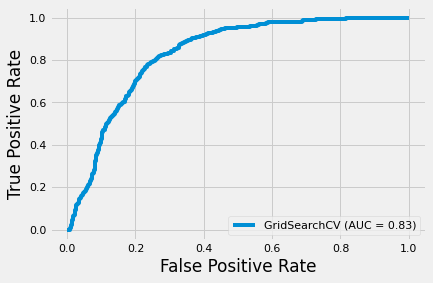

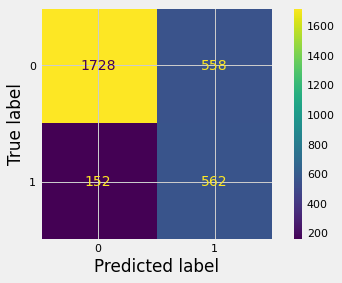

In [172]:
metrics.plot_roc_curve(logReg, X_test, y_test) 
metrics.plot_confusion_matrix(logReg, X_test, y_test)

### Support Vector Machine

In [173]:
# SVM
cls_svm = make_pipeline(StandardScaler(),
                        SVC(C=0.01,
                            gamma=0.1,
                            kernel="poly",
                            degree=5,
                            coef0=10,
                            probability=True))

cls_svm.fit(X_train, y_train)

cls_svm_cv_scores = cross_val_score(cls_svm, # score da validação cruzda
                                X=X_train,
                                y=y_train,
                                scoring="f1",
                                cv=10,
                                n_jobs=-1)

# Print Cross Validation
print("\033[1m" + "\033[94m" + "Melhores 10 - folds e validação cruzada:: {:.2f}%".format(
       np.mean(cls_svm_cv_scores) * 100))

Melhores 10 - folds e validação cruzada:: 96.42%


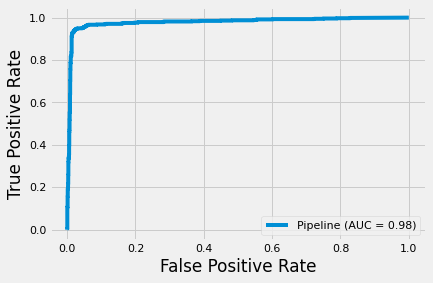

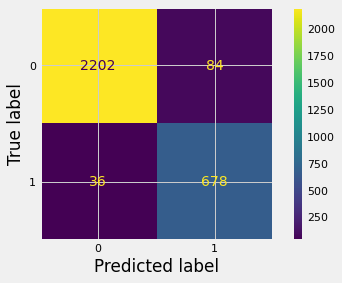

In [174]:
metrics.plot_roc_curve(cls_svm, X_test, y_test) 
metrics.plot_confusion_matrix(cls_svm, X_test, y_test)

In [175]:
# Plot resultados para todos os classificadores
estimators = {
               "Randon Forest": classificador,
              "Logistic Regression": logReg,
             "Support Vector Machine": cls_svm,
              "Gradient Boosting T": gridSearch_gb,
              "K-Nearest Neighbor ": grid_knn}
#metrics.roc_curve(estimators, X_test, y_test, (12, 8))

print("A accurácia e melhor score dos modelos para os dados são:")
for estimator in estimators.keys():
    print("{}: {:.2f}%, {:.2f}%.".format(estimator,
        accuracy_score(y_test, estimators[estimator].predict(X_test)) * 100,
         f1_score(y_test, estimators[estimator].predict(X_test)) * 100))

A accurácia e melhor score dos modelos para os dados são:
Randon Forest: 99.27%, 98.44%.
Logistic Regression: 76.33%, 61.29%.
Support Vector Machine: 96.00%, 91.87%.
Gradient Boosting T: 98.00%, 95.79%.
K-Nearest Neighbor : 97.23%, 94.33%.


### Importância das features

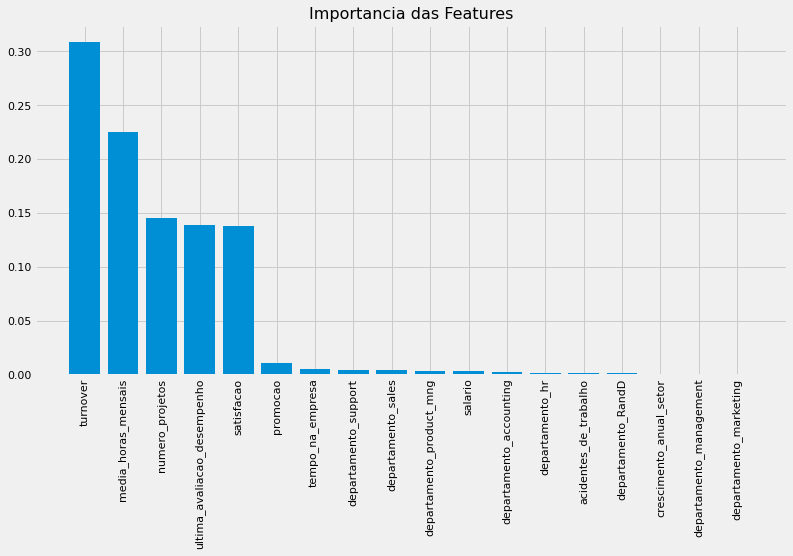

In [180]:
# Refit RF classifier
classificador_rf = RandomForestClassifier(n_estimators=50,
                                criterion="entropy",
                                max_features=0.4,
                                min_samples_leaf=1,
                                class_weight="balanced",
                                n_jobs=-1,
                                random_state=123)


classificador_rf.fit(StandardScaler().fit_transform(X_train), y_train)

# Plot features importance
importancia = classificador_rf.feature_importances_
indices = np.argsort(classificador_rf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 19), importancia[indices], align="center")
plt.xticks(range(1, 19), df.columns[df.columns != "left"][indices], rotation=90)
plt.title("Importancia das Features", {"fontsize": 16});